# Theory

### Network Architecture

This network uses two AlexNets without the last classification layer. 
The final output is the euclidean distance between the 4096 dimensional feature 
vectors of the two networks. Both the networks have different weights,
hence it is different from a Siamese network, where both the networks
have exactly the same weights. 

![network](resources/dual_net.png)


### Loss Function
The distance should be close to 0 for matching pairs.

In order to train the model, we use contrastive loss function. The function is distance squared for matching pairs. In case of non-matching pairs, it is the distance from the margin. If the distance of non-matching pairs is already more than the margin, the loss is 0.  
$$loss = label \times {distance}^2 + (1 - label) \times {(\max{(0, margin - distance)})}^2$$

Note that $label = 1$ for matching pair, $label = 0$ for non-matching pair.
We have chosen the $margin = 100$.

# Experiments

During the experiments, it was observed that the network was often got stuck at a loss of about $2500$. This was because the network learnt such parameters which resulted into a distance of $50$ units for both matching and non-matching pairs.  Here is a list of experiments and their resulting training losses.

| No of Image Pairs |                       Optimizer Parameters                      | No of Epochs |                 Training Loss                 |                     Model                    |
|:-----------------:|:---------------------------------------------------------------:|:------------:|:---------------------------------------------:|:--------------------------------------------:|
| 4                 | Adam (lr = 0.0005)                                              | 300          | Slow and constant decay to ~400               | 2 AlexNets initialized randomly              |
| 249               | Adam (lr = 0.0005)                                              | 100          | Decreases rapidly and gets stuck at ~2500     | 2 AlexNets initialized randomly              |
| 249               | Adam (lr = 0.005)                                               | 100          | Decreases rapidly and gets stuck at ~2500     | 2 AlexNets initialized randomly              |
| 249               | SGD (lr = 1e-5, decay = 5e-5, momentum = 0.9, nesterov = False) | 183          | Decreases rapidly and gets stuck at ~2500     | 2 AlexNets initialized randomly              |
| 249               | SGD (lr = 1e-5, decay = 5e-5, momentum = 0.9, nesterov = False) | 1            | Increases rapidly to infinity (nan in python) | 2 AlexNets initialized with ImageNet weights |
| 249               | Adam (lr = 0.0005)                                              | 151          | Slow and constant decay to ~419               | 2 AlexNets initialized with ImageNet weights |
| 7012              | Adam (lr = 0.0005)                                              | 72           | Slow and constant decay to ~511               | 2 AlexNets initialized with ImageNet weights |

### Insights
* It seems like the problem I was facing was due to bad initialization. Earlier I was using randomly initialized weights for the neural network, and the network was outputting almost the same distance for both matching and non-matching image pairs.
* Even though the network pretrained with ImageNet weights does not have explicit category of aerial images, the contours and shapes it has learnt can be utilised to differentiate between matching and non-matching image pairs. 
* Initalizing the network with Places365 weights might even be a better option (WIP).

The training and validation loss from the last case are shown in image below:  
**[NEW] I discovered a mistake in code. Validation loss is incorrect. However, training loss is correct. I will update the validation results when I am able to run it again.**
![train_loss](resources/train_loss.png)

### Results (from last case)
The result of training on contrastive loss can be seen in this histogram. The matching pairs have a distance closer to 0, and the non-matching pairs have higher distances.
![train_hist](resources/train_hist.png)

# Challenges

The challenges faced are mostly implementational in nature.
1. **Training Time:** It takes painfully long time to train a neural network. The network from the last case which showed good results trained for about **21 hours**. The ones with lesser image pairs have also taken 3-4 hours to train. I have used my own laptop GPU (good old Nvidia GeForce 940M 4GB). Note that I have only used the images from a single city for training without any data augmentation, thus taking only 6.81 percent of the entire training dataset. It is almost impossible to work on entire dataset with this training speed.
2. Unusable laptop during training time. Also long training instances could harm the computer because of heating and lack of ventilation in laptop.
3. **Finding good initialization:** Explained above
4. Determining the hyperparameters for optimization is experimental.
5. Available training data (9 cities: 36.7 GB), available test data (3 cities, 6.2 GB). It is expected that the lesser the data fed to the network, the lesser is the generalization capability of the network. Hence, working with less data caps the performance of the network.

### Workarounds

I have played around with Google colab in order to see whether it can help reduce the training time. Colab is an online platform where one can run a jupyter notebook on cloud. They also provide the user with a GPU. The only caveat is that the session gets timed out in 12 hours, after which all the variables are lost.

In the past week, I have bought some extra storage and worked on migrating the training data to Google drive. I made some observations, which are listed below.

1. Training a neural network can be slow because of two reasons:
    * Using mediocre GPU, or not using one at all
    * Loading training data which is big in size can be slow
2. Google colab offers around 35-37 GB of disk space in VM every session. Loading data from this space is fast. But I cannot load the entire data here. There is not enough space.
3. All data in the VM is wiped out after the time out (12 hours).
4. Loading images from Google drive is very slow.
5. Training on colab GPU is slightly slower than my laptop's GPU.
6. **[NEW] Colab has GPU usage limits. One cannot train models for a long duration. Ran into this issue:**  
`As a result, users who use Colab for long-running computations, or users who have recently used more resources in Colab, are more likely to run into usage limits and have their access to GPUs and TPUs temporarily restricted.`

**Workaround** 
**[NEW]** Striking out as this workaround was not succesful due to usage limits.
<s>_Solving the slow Google drive data loading problem_  
I have stored all the training data in zipped format in Google drive. At training time, I can unzip this data in VM disk. Since we cannot unzip the entire dataset (there is not enough space in VM disk), we upzip the data sequentially. Hence, one solution can be to break the training data into 2 chunks. Use the first chunk for training, delete it, and then use the second chunk for training.
Unzipping the data into VM disk takes a few minutes. But this data can now be loaded quickly into memory while training. Sequential loading and unzipping data into VM disk can help the data loading process.</s>

<s>_Solving the slow Google colab GPU problem_ ???  
_Colab disconnects after 12 hours_ ???</s>

Following [this guide](https://towardsdatascience.com/maximize-your-gpu-dollars-a9133f4e546a), I am thinking of signing up for Google cloud with a good GPU. It gives $300 initial credits.

# TODO
* Explore Google Cloud
* Get weights for pretrained network with Places365 in torch format
* Explore autoencoders for matching task
* Explore shape based feature matching
* Try out one shot matching network
* ...

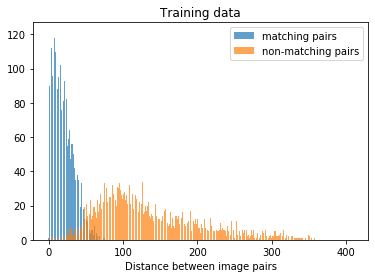

In [17]:
# code for drawing histograms
import numpy as np
import matplotlib.pyplot as plt

train_match_hist = np.array([  1.,  90., 121., 114., 112.,  96., 104., 108., 118., 110., 120.,
        103.,  88.,  95.,  96., 119., 102.,  76., 111.,  89.,  81.,  93.,
         85.,  89.,  82.,  55.,  66.,  59.,  64.,  47.,  63.,  56.,  56.,
         50.,  35.,  42.,  35.,  39.,  41.,  38.,  35.,  28.,  32.,  19.,
         33.,  26.,  29.,  18.,  12.,  11.,  14.,  12.,  11.,   8.,   8.,
          6.,   4.,   8.,   6.,   6.,   3.,   4.,   8.,   0.,   4.,   0.,
          2.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.])
train_nonma_hist = np.array([ 0.,  0.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  0.,  3.,  0.,  2.,  0.,  0.,  4.,  3.,  3.,
         5.,  2.,  7.,  7.,  4.,  5.,  3.,  2.,  1.,  3.,  7.,  4.,  8.,
         6.,  4.,  6.,  9.,  6.,  8., 10., 11., 11., 19.,  7., 12., 21.,
        14., 19., 12., 15., 23.,  7., 12., 14., 19., 13., 19., 16., 13.,
        19., 23., 16., 21., 22., 27., 18., 22., 24., 22., 33., 26., 20.,
        30., 22., 24., 25., 25., 25., 30., 24., 32., 27., 34., 31., 23.,
        20., 27., 31., 30., 33., 28., 29., 26., 24., 15., 27., 28., 23.,
        27., 26., 21., 27., 27., 32., 21., 25., 26., 27., 18., 18., 10.,
        26., 24., 21., 21., 16., 22., 20., 22., 21., 34., 21., 15., 16.,
        20., 17., 17., 20., 22., 20., 14., 13., 15., 20., 14., 11., 16.,
        11., 21., 14., 18., 16., 12., 12., 12., 12., 11., 14., 11., 13.,
        17., 18., 10., 18., 10.,  8., 11.,  9., 16.,  7.,  7., 13.,  8.,
         7.,  8., 14., 14., 12.,  5., 14.,  9., 12., 12., 13., 16., 13.,
        15.,  9.,  8., 13.,  9., 10., 11.,  7., 14., 17.,  5., 11.,  9.,
        11.,  9.,  7., 12.,  9., 12.,  8.,  7.,  7.,  4.,  6.,  9.,  7.,
         8., 17., 12.,  7.,  8.,  5.,  6.,  5.,  9., 10., 13.,  8.,  8.,
         4.,  5.,  5.,  6.,  8.,  6.,  5.,  9.,  5.,  6., 10.,  6.,  6.,
         7.,  6.,  3.,  6.,  5.,  2.,  6.,  8.,  5.,  8.,  2.,  3., 11.,
         8.,  6.,  6.,  1.,  6.,  3., 11.,  3.,  5.,  4.,  5.,  2.,  5.,
         3.,  6.,  4.,  3.,  6.,  0.,  6.,  4.,  2.,  3.,  1.,  3.,  2.,
         6.,  3.,  6.,  6.,  1.,  5.,  4.,  1.,  4.,  4.,  3.,  1.,  3.,
         5.,  5.,  5.,  4.,  4.,  1.,  6.,  2.,  2.,  6.,  1.,  2.,  7.,
         3.,  1.,  2.,  2.,  2.,  5.,  5.,  1.,  2.,  2.,  2.,  0.,  3.,
         4.,  3.,  6.,  2.,  6.,  2.,  3.,  1.,  3.,  1.,  3.,  2.,  0.,
         3.,  3.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  3.,
         2.,  2.,  0.,  1.,  0.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.])
plt.bar(range(len(train_match_hist)), train_match_hist, label = 'matching pairs', alpha = 0.7)
plt.bar(range(len(train_nonma_hist)), train_nonma_hist, label = 'non-matching pairs', alpha = 0.7)
plt.legend(loc='best')
plt.title('Training data')
plt.xlabel('Distance between image pairs')
plt.show()

3505.0